Read the vision transformer paper here: https://arxiv.org/pdf/2010.11929.pdf

In [1]:
import torch 
import torchvision 
from torchvision import transforms

import matplotlib.pyplot as plt

from going_modular import engine, data_setup
from helper_functions import set_seeds, download_data, plot_loss_curves

C:\Users\leopu\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [6]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x19daabe8c10>,
 ['pizza', 'steak', 'sushi'])

In [7]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

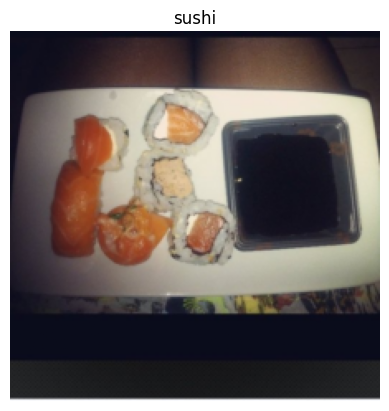

In [8]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [9]:
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / (patch_size ** 2))
print(f"Number of patches (N) with image height (H={height}), width (W={width}), and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224), and patch size (P=16): 196


In [10]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image): (196, 768)


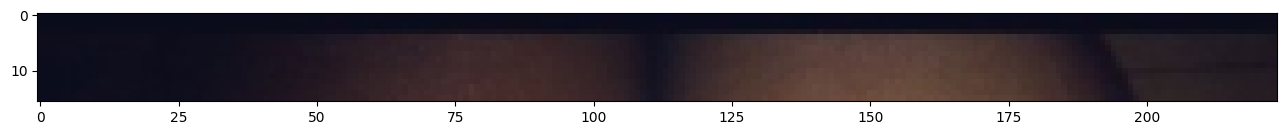

In [11]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [12]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image must be divisible by patch size"

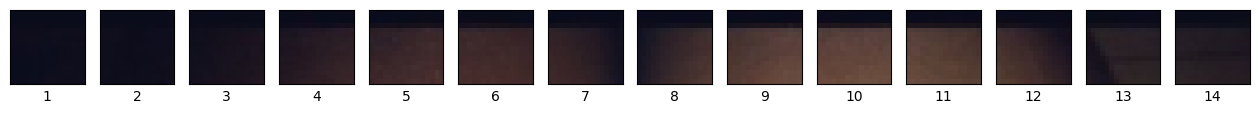

In [13]:
fig, axs = plt.subplots(
    nrows=1, 
    ncols=img_size // patch_size,
    sharex=True, 
    sharey=True,
    figsize=(patch_size, patch_size)
)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


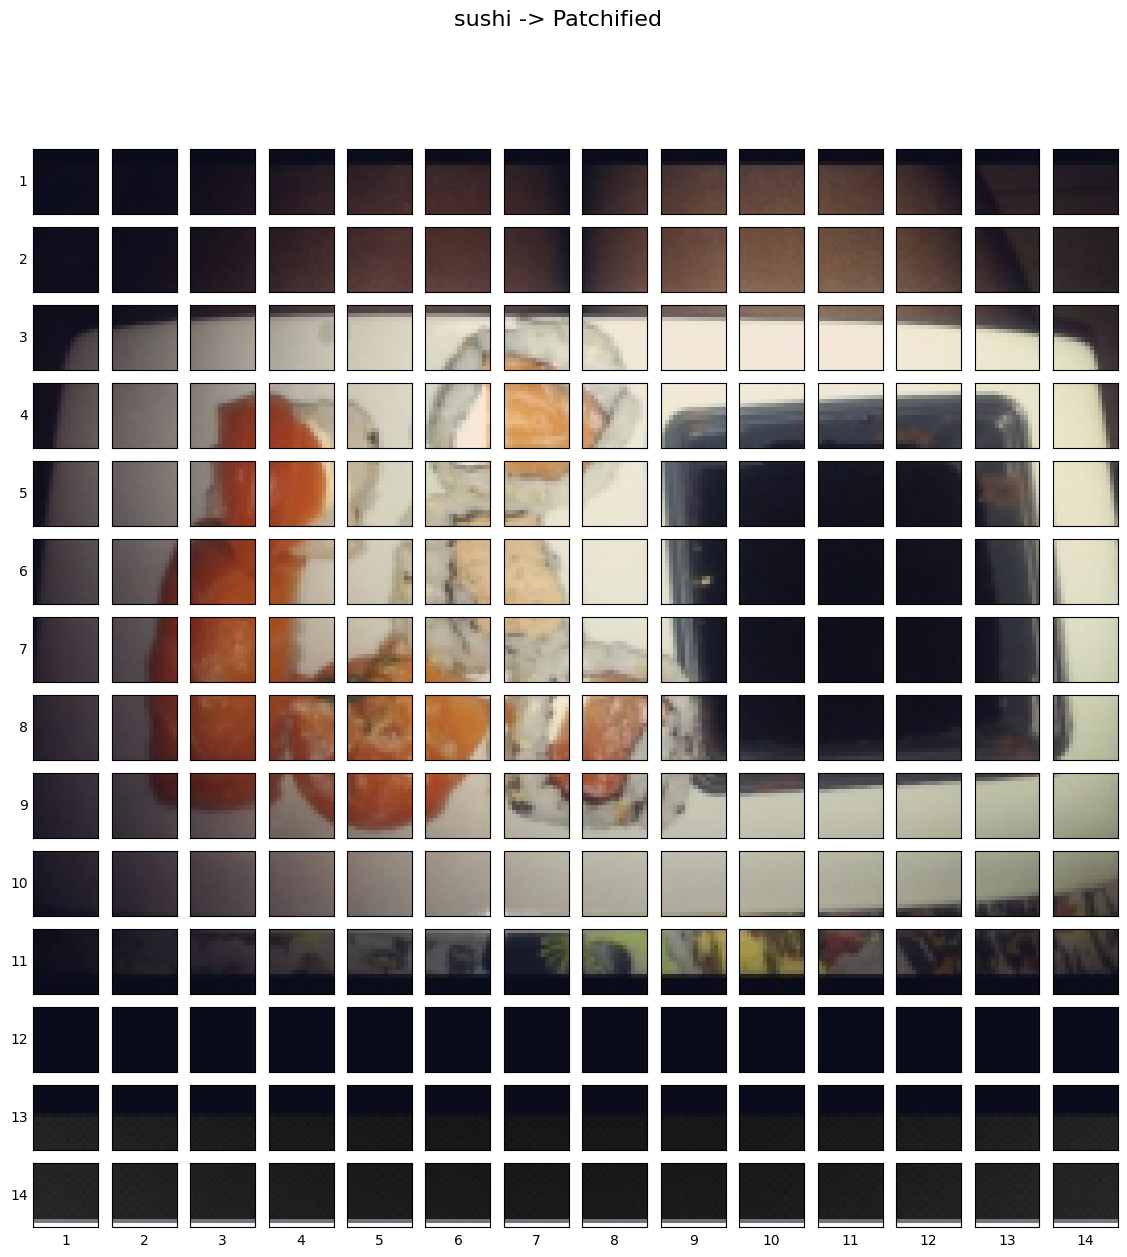

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [15]:
from torch import nn 

patch_size = 16 

# Create the Conv2d layer with hyperparamerters form the ViT paper
conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size, 
    stride=patch_size,
    padding=8
)

In [16]:
# Pass one image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension to it
print(image_out_of_conv.shape)

torch.Size([1, 768, 15, 15])


torch.Size([1, 768, 15, 15]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

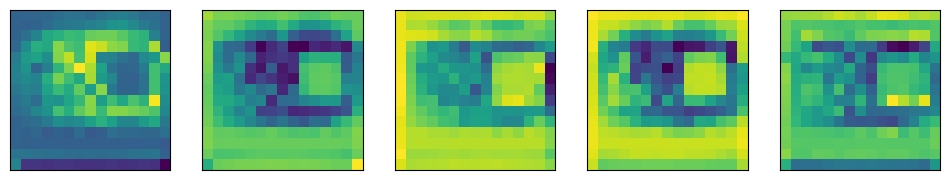

In [17]:
# Plot 5 random convolutional feature maps 
import random 
random_indexes = random.sample(range(0, 758), k=5)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # inex on the output tensr of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [18]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0357,  0.0462,  0.0479,  0.0558,  0.0716,  0.0772,  0.0712,
            0.0557,  0.0966,  0.1103,  0.1090,  0.0846,  0.0563,  0.0635,
            0.0335],
          [ 0.0330,  0.0429,  0.0571,  0.0769,  0.1033,  0.1083,  0.0994,
            0.0709,  0.1454,  0.1718,  0.1638,  0.1469,  0.0880,  0.0789,
            0.0472],
          [ 0.0328,  0.0920,  0.1990,  0.2595,  0.3109,  0.3584,  0.2788,
            0.3286,  0.3276,  0.3141,  0.3242,  0.3387,  0.3291,  0.1398,
            0.0419],
          [ 0.0369,  0.1780,  0.2450,  0.1826,  0.3487,  0.3074,  0.3254,
            0.3459,  0.3828,  0.3063,  0.2256,  0.2134,  0.1894,  0.3569,
            0.1286],
          [ 0.0687,  0.1833,  0.2025,  0.1617,  0.3707,  0.3814,  0.3325,
            0.3542,  0.3218,  0.0572,  0.0223,  0.0322,  0.1061,  0.4687,
           -0.0564],
          [ 0.0631,  0.1534,  0.0935,  0.1320,  0.3449,  0.3303,  0.3745,
            0.4478,  0.3375,  0.0651,  0.0458,  0.0455,  0.0603,  0.2509,
       

In [19]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 15, 15]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [20]:
# Create flatten layer
flatten = nn.Flatten(
    start_dim=2, # flatten feature_map_height (dimension 2)
    end_dim=3  # flatten feature_map_width (dimension 3)
) 

In [21]:
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 225])


In [22]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 225, 768]) -> [batch_size, num_patches, embedding_size]


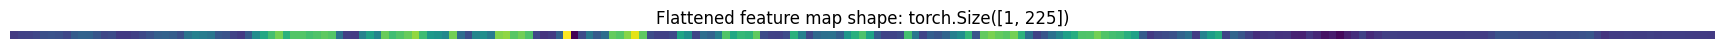

In [23]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [24]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0357,  0.0462,  0.0479,  0.0558,  0.0716,  0.0772,  0.0712,  0.0557,
           0.0966,  0.1103,  0.1090,  0.0846,  0.0563,  0.0635,  0.0335,  0.0330,
           0.0429,  0.0571,  0.0769,  0.1033,  0.1083,  0.0994,  0.0709,  0.1454,
           0.1718,  0.1638,  0.1469,  0.0880,  0.0789,  0.0472,  0.0328,  0.0920,
           0.1990,  0.2595,  0.3109,  0.3584,  0.2788,  0.3286,  0.3276,  0.3141,
           0.3242,  0.3387,  0.3291,  0.1398,  0.0419,  0.0369,  0.1780,  0.2450,
           0.1826,  0.3487,  0.3074,  0.3254,  0.3459,  0.3828,  0.3063,  0.2256,
           0.2134,  0.1894,  0.3569,  0.1286,  0.0687,  0.1833,  0.2025,  0.1617,
           0.3707,  0.3814,  0.3325,  0.3542,  0.3218,  0.0572,  0.0223,  0.0322,
           0.1061,  0.4687, -0.0564,  0.0631,  0.1534,  0.0935,  0.1320,  0.3449,
           0.3303,  0.3745,  0.4478,  0.3375,  0.0651,  0.0458,  0.0455,  0.0603,
           0.2509,  0.2047,  0.0526,  0.1323,  0.1103,  0.1703,  0.3268,  0.2578,
           0.294

In [25]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    def __init__(
            self,
            in_channels: int=3,
            patch_size: int=16,
            embedding_dim: int=768
    ):
        super().__init__()
        
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        self.flatten = nn.Flatten(
            start_dim=2,
            end_dim=3
        )

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisibe by patch_size, image shape: {image_resolution}, patch_size: {patch_size}"

        # Perform the forward pass 
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [26]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [27]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0877,  0.0102, -0.0513,  ...,  0.0631, -0.0262,  0.0199],
         [-0.0916,  0.0084, -0.0506,  ...,  0.0623, -0.0291,  0.0249],
         [-0.1237,  0.0051, -0.0488,  ...,  0.0799, -0.0375,  0.0285],
         ...,
         [-0.3503,  0.0900, -0.3855,  ...,  0.1192,  0.0827,  0.0274],
         [-0.3609,  0.0878, -0.3867,  ...,  0.1260,  0.0821,  0.0347],
         [-0.3632,  0.0918, -0.3882,  ...,  0.1355,  0.0767,  0.0423]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [28]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [39]:
class_token = nn.Parameter(
    torch.randn(batch_size, 1, embedding_dimension),
    requires_grad=True
)
class_token

Parameter containing:
tensor([[[-1.0264e+00, -2.4631e+00,  1.7033e-01, -3.7916e-01, -2.1754e-01,
           3.8989e-01, -1.8656e+00, -3.9537e-02,  3.7168e-01,  1.3684e-01,
           7.1420e-01, -6.7596e-01,  7.3858e-01, -9.6839e-01, -1.6690e-01,
           9.7277e-01,  6.5336e-01, -6.1852e-01, -4.7906e-01, -3.5825e-01,
          -9.9326e-01,  4.0255e-01, -1.2952e+00, -8.4350e-01, -3.5483e-01,
           9.6675e-01, -1.7756e+00, -2.0824e-01, -1.4956e-01,  1.0597e-01,
          -1.5228e-01,  1.0666e-01, -2.3402e+00,  2.2134e-01,  5.0493e-01,
          -1.1426e-02,  2.4198e-01,  1.7191e-02,  3.6597e-01,  1.9193e+00,
           1.6159e-01, -3.2299e-01, -1.2357e+00,  1.7547e+00,  1.8828e+00,
          -8.9820e-01, -2.1164e+00, -1.8879e-01, -5.7740e-01, -2.4357e-01,
          -5.8623e-01, -5.0295e-01,  3.2793e-01,  7.6678e-01,  4.9903e-01,
          -5.3723e-01,  6.7444e-01,  1.9478e+00,  1.6325e+00,  8.9679e-01,
           7.2680e-01,  4.1643e-01,  1.3130e+00, -2.2983e-02, -2.0443e-01,
   

In [40]:
# add class token embedding to the front of the patch embedding 
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
patch_embedded_image_with_class_embedding

tensor([[[-1.0264, -2.4631,  0.1703,  ...,  0.1468,  1.3768,  0.5802],
         [-0.0877,  0.0102, -0.0513,  ...,  0.0631, -0.0262,  0.0199],
         [-0.0916,  0.0084, -0.0506,  ...,  0.0623, -0.0291,  0.0249],
         ...,
         [-0.3503,  0.0900, -0.3855,  ...,  0.1192,  0.0827,  0.0274],
         [-0.3609,  0.0878, -0.3867,  ...,  0.1260,  0.0821,  0.0347],
         [-0.3632,  0.0918, -0.3882,  ...,  0.1355,  0.0767,  0.0423]]],
       grad_fn=<CatBackward0>)

In [41]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [45]:
# Creating pos embedding
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension 
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create a learnable, 1D pos embedding
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches+1, embedding_dimension)
)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [49]:
# Add the position embedding to the patch and class token embedding
patch_and_token_embedding = patch_embedded_image_with_class_embedding + position_embedding # we can do this because they are the same shape
patch_and_token_embedding, patch_and_token_embedding.shape

(tensor([[[-0.0264, -1.4631,  1.1703,  ...,  1.1468,  2.3768,  1.5802],
          [ 0.9123,  1.0102,  0.9487,  ...,  1.0631,  0.9738,  1.0199],
          [ 0.9084,  1.0084,  0.9494,  ...,  1.0623,  0.9709,  1.0249],
          ...,
          [ 0.6497,  1.0900,  0.6145,  ...,  1.1192,  1.0827,  1.0274],
          [ 0.6391,  1.0878,  0.6133,  ...,  1.1260,  1.0821,  1.0347],
          [ 0.6368,  1.0918,  0.6118,  ...,  1.1355,  1.0767,  1.0423]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

## Multihead Self-Attention